In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [77]:
# Charger les données prétraitées
df = pd.read_csv("../preprocessing/preprocessed_timeseries.csv", parse_dates=True)

# S'assurer que l'index est une colonne de type datetime
# df.index = pd.to_datetime(df.index)

# Identifier les colonnes cibles (toutes sauf la date)
target_columns = df.columns[-1]

# Dictionnaire pour stocker les prédictions
forecast_results = {}
type(df)


pandas.core.frame.DataFrame

In [78]:
# create_features est essentielle pour transformer une série temporelle brute en un format exploitable par XGBoost
def create_features(df, column, lags=25):
    """
    Crée des features pour la colonne donnée :
    - Décalages temporels (lags)
    - Moyennes mobiles
    """
    data = df[[column]].copy()
    
    # Créer des lag features (valeurs passées)
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data[column].shift(lag)


    # Détecter la fréquence
    detected_freq = pd.infer_freq(df.index)
    
    print("***",detected_freq,"***")
    if detected_freq in ["D", "B"]:  # Quotidienne ou Business Days
        rolling_windows = [7, 14, 30]
    elif detected_freq in ["MS", "M"]:  # Mensuelle
        rolling_windows = [3, 6, 12]
    elif detected_freq in ["YS", "Y"]:  # Annuelle
        rolling_windows = [2, 3, 5]
    else:
        pass

    # Appliquer les moyennes mobiles pour detecter la saisonnalité
    for window in rolling_windows:
        data[f'rolling_mean_{window}'] = data[column].shift(1).rolling(window=window).mean()

    # Supprimer les valeurs NaN générées par les décalages
    data.dropna(inplace=True)
    #data.to_csv("data3.csv")
    return data



In [79]:
def OldXGBoost(df, target_columns):    
    for column in target_columns:
        print(f"Training XGBoost model for {column}...")

        # Créer les features
        data = create_features(df, column)

        # Séparer les features (X) et la cible (y)
        X = data.drop(columns=[column])
        y = data[column]

        # Séparer Train/Test (80% - 20%)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        # Entraîner le modèle XGBoost
        model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
        model.fit(X_train, y_train)

        # Faire des prédictions
        y_pred = model.predict(X_test)

        # Calculer l'erreur
        mse = mean_squared_error(y_test, y_pred)
        print(f"MSE for {column}: {mse:.4f}")

        # Sauvegarder les résultats
        forecast_results[column] = pd.DataFrame({"ds": X_test.index, "yhat": y_pred})

        # Visualisation
        plt.figure(figsize=(10, 5))
        plt.plot(y_train.index, y_train, label="Train")
        plt.plot(y_test.index, y_test, label="Test", color="orange")
        plt.plot(y_test.index, y_pred, label="Forecast", linestyle="dashed", color="red")
        plt.title(f"Prédictions XGBoost pour {column}")
        plt.legend()
        plt.show()

    # Sauvegarder les prévisions
    for col, forecast in forecast_results.items():
        forecast.to_csv(f"forecast_xgboost_{col}.csv", index=False)

    print("Toutes les prédictions XGBoost ont été enregistrées.")


In [80]:
def create_time_series_features(df, date_column=None, target_column=None, time_steps=3):
    """
    Create lagged features for multivariate time series from DataFrame
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input time series DataFrame
    date_column : str, optional
        Name of the date column (if exists)
    target_column : str or list, optional
        Column(s) to predict
    time_steps : int, optional (default=3)
        Number of previous time steps to use as features
    
    Returns:
    --------
    X : numpy.ndarray
        Feature matrix with lagged features
    y : numpy.ndarray
        Target variable (next time step)
    """
    # If no target column specified, assume last numeric column
    print(type(df))
    if target_column is None:
        target_column = df.columns[-1]
    
    # Remove date column if specified
    if date_column and date_column in df.columns:
        feature_df = df.drop(columns=[date_column])
    else:
        feature_df = df.copy()
    
    # Ensure target is a list for consistent handling
    if isinstance(target_column, str):
        target_column = [target_column]
    
    # Separate features and target
    X_cols = [col for col in feature_df.columns if col not in target_column]
    
    # Prepare data for time series feature creation
    data_array = feature_df.values
    
    X, y = [], []
    for i in range(len(data_array) - time_steps):
        # Create input sequence of previous time_steps
        X.append(data_array[i:i+time_steps].flatten())
        # Target is the next time step's values for specified target column(s)
        y.append(feature_df[target_column].iloc[i+time_steps].values)
    
    return np.array(X), np.array(y)

In [81]:
def train_xgboost_timeseries(df, date_column=None, target_column=None, 
                              time_steps=3, test_size=0.2, random_state=42):
    """
    Train XGBoost model for multivariate time series prediction
    
    Parameters:
    -----------
    df : pd.DataFrame
        Input time series DataFrame
    date_column : str, optional
        Name of the date column
    target_column : str or list, optional
        Column(s) to predict
    time_steps : int, optional
        Number of previous time steps to use as features
    test_size : float, optional
        Proportion of data to use for testing
    random_state : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    dict: Contains model, test data, predictions, and evaluation metrics
    """
    # Create features and target
    X, y = create_time_series_features(
        df, 
        date_column=date_column, 
        target_column=target_column, 
        time_steps=time_steps
    )
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Prepare DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dtest = xgb.DMatrix(X_test_scaled, label=y_test)
    
    # Define XGBoost parameters
    params = {
        'objective': 'reg:squarederror',  # Regression objective
        'eval_metric': 'rmse',  # Root Mean Squared Error
        'max_depth': 5,
        'learning_rate': 0.1,
        'n_estimators': 100
    }
    
    # Train the model
    model = xgb.train(
        params, 
        dtrain, 
        num_boost_round=100,
        evals=[(dtest, 'test')],
        early_stopping_rounds=10,
        verbose_eval=10
    )
    
    # Make predictions
    predictions = model.predict(dtest)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    
    return {
        'model': model,
        'X_test': X_test,
        'y_test': y_test,
        'predictions': predictions,
        'mse': mse,
        'mae': mae,
        'scaler': scaler
    }

In [82]:
results = train_xgboost_timeseries(
    df, 
    date_column='Period',
    time_steps=5
)

<class 'pandas.core.frame.DataFrame'>
[0]	test-rmse:22344808.15484
[10]	test-rmse:8483267.91264


[20]	test-rmse:3220697.97927
[30]	test-rmse:1222745.99334
[40]	test-rmse:464218.00782
[50]	test-rmse:176241.99799
[60]	test-rmse:66914.00093
[70]	test-rmse:24945.99992
[80]	test-rmse:9644.00000
[90]	test-rmse:5708.00000
[99]	test-rmse:3586.00000


C:\Users\raedb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [01:13:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [83]:
def plot_xgboost_performance(model, X_test, y_test):
    """
    Plot XGBoost model performance graphs
    
    Parameters:
    -----------
    model : xgboost.Booster
        Trained XGBoost model
    X_test : numpy.ndarray
        Test feature matrix
    y_test : numpy.ndarray
        Test target values
    
    Returns:
    --------
    matplotlib.figure.Figure: Performance visualization figure
    """
    # Prepare test data
    dtest = xgb.DMatrix(X_test)
    
    # Make predictions
    y_pred = model.predict(dtest)
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    # Plot 1: Actual vs Predicted Values
    ax1.scatter(y_test, y_pred, alpha=0.5)
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2)
    ax1.set_title('Actual vs Predicted Values')
    ax1.set_xlabel('Actual Values')
    ax1.set_ylabel('Predicted Values')
    
    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))
    
    # Add metrics text
    ax1.text(0.05, 0.95, 
             f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}', 
             transform=ax1.transAxes, 
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Plot 2: Residuals (Prediction Errors)
    # residuals = y_test - y_pred
    # ax2.scatter(y_pred, residuals, alpha=0.5)
    # ax2.axhline(y=0, color='r', linestyle='--')
    # ax2.set_title('Residual Plot')
    # ax2.set_xlabel('Predicted Values')
    # ax2.set_ylabel('Residuals')
    
    # # Add a histogram of residuals
    # ax2.hist(residuals, bins=30, alpha=0.3, orientation='horizontal')
    
    plt.tight_layout()
    plt.show()
    
    return fig


def plot_xgboost_learning_curves(evals_result):
    """
    Plot XGBoost learning curves
    
    Parameters:
    -----------
    evals_result : dict
        Evaluation results from XGBoost training
    
    Returns:
    --------
    matplotlib.figure.Figure: Learning curves visualization
    """
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot training and validation error
    plt.plot(evals_result['test']['rmse'], label='Test RMSE')
    plt.title('XGBoost Learning Curves')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Root Mean Squared Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return plt.gcf()


In [84]:
len(results['X_test'])

19

C:\Users\raedb\AppData\Local\Temp\ipykernel_4840\656085751.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  r2 = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))


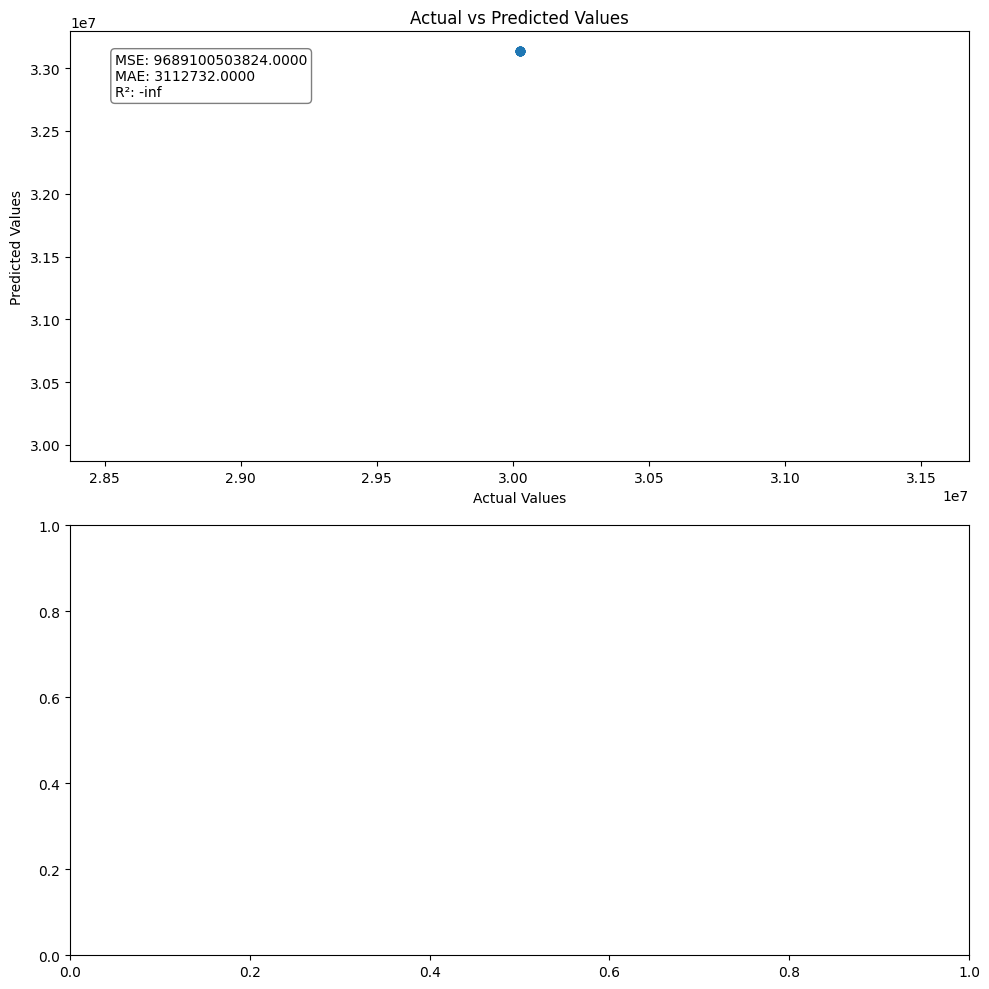

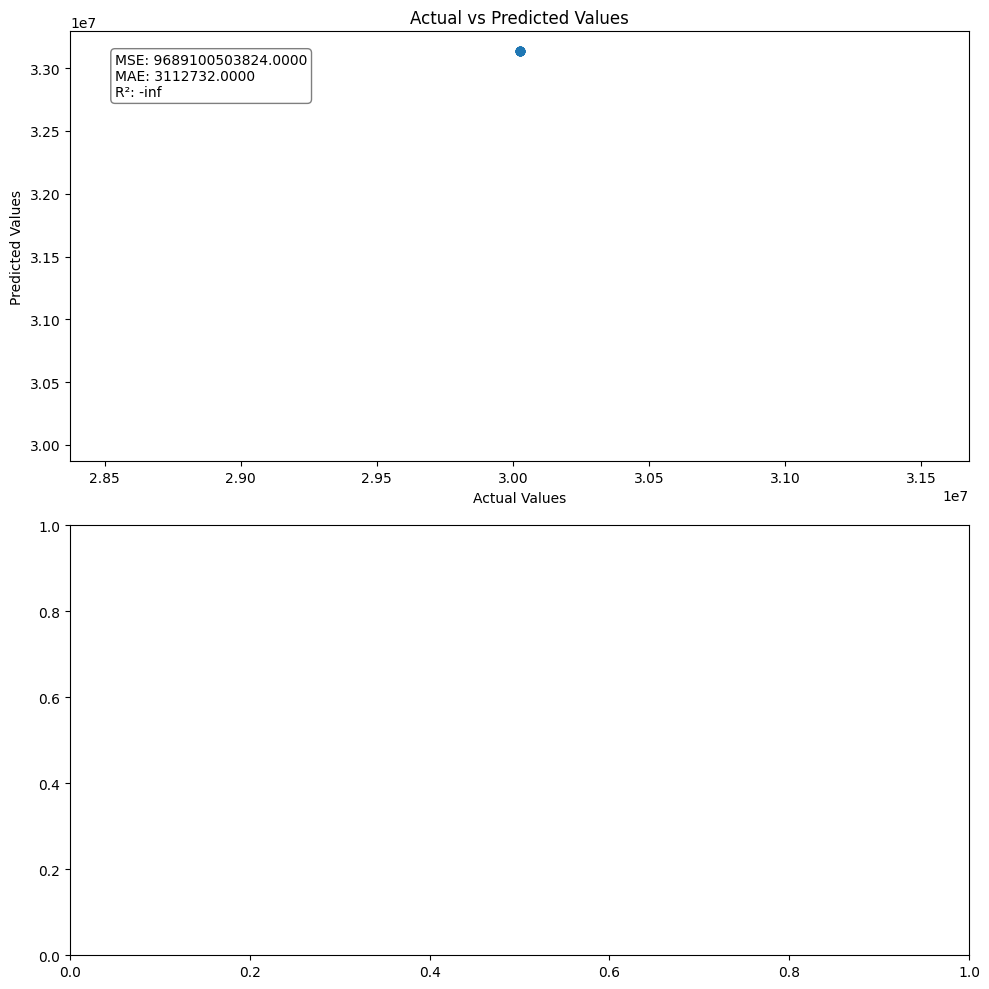

In [85]:
# Plot performance graphs
plot_xgboost_performance(results['model'],results['X_test'], results['y_test'])

# Plot learning curves
# plot_xgboost_learning_curves(evals_result)